In [40]:
import numpy as np
import pandas as pd
import scipy as stats

from statistics import median
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [41]:
jails = pd.read_csv("all_deaths_clean")

jails.columns

Index(['id', 'state', 'county', 'jail', 'year', 'date_of_death', 'full_name',
       'last_name', 'first_name', 'mid_name', 'suffix', 'date_incarcerated',
       'cause_short', 'cause_detail', 'dob', 'yob', 'age', 'race',
       'race_detail', 'gender', 'custody_status', 'what_info_from_media',
       'num_media_descriptors'],
      dtype='object')

In [42]:
#all columns we want
cols_of_interest = jails[["cause_short", "age", "race", "custody_status", "gender"]].dropna()

In [43]:
print(cols_of_interest.nunique())

print(cols_of_interest["race"].unique())

print(cols_of_interest["cause_short"].unique())

#I see that there is very few of race categories PI, O, and A- gonna remove those for now :( since it is causing asymmetry in the train test split of the model
print(cols_of_interest["race"].value_counts())

#very very few of u and a categories represented in cause short, will drop those as well
print(cols_of_interest["cause_short"].value_counts())

PI_mask = cols_of_interest["race"] != "PI"
O_mask = cols_of_interest["race"] != "O"
A_mask = cols_of_interest["race"] != "A"

u_mask = cols_of_interest["cause_short"] != "u"
a_mask = cols_of_interest["cause_short"] != "a"

cols_of_interest = cols_of_interest[PI_mask & O_mask & A_mask & u_mask & a_mask]

cause_short        8
age               73
race               7
custody_status     2
gender             2
dtype: int64
['W' 'B' 'H' 'AI' 'O' 'PI' 'A']
['s' 'm' 'da' 'ac' 'h' 'o' 'a' 'u']
W     1491
B      833
H      184
AI      40
A       11
O        8
PI       2
Name: race, dtype: int64
m     1373
s      825
da     237
h       56
ac      46
o       28
u        3
a        1
Name: cause_short, dtype: int64


In [47]:
from sklearn.model_selection import train_test_split

#split into predictive info and target
data = cols_of_interest.drop(columns= ["gender"])
target = cols_of_interest["gender"]

#split into training and test
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.7, random_state=999)

print(train_data["race"].unique())
print(test_data["race"].unique())
print(train_data["cause_short"].unique())
print(test_data["cause_short"].unique())

['B' 'W' 'H' 'AI']
['W' 'H' 'B' 'AI']
['m' 's' 'h' 'da' 'ac' 'o']
['s' 'm' 'ac' 'da' 'h' 'o']


c:\Users\noell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


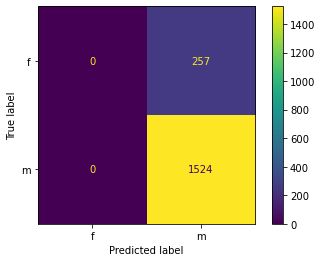

In [48]:

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt # to better format confusion matrix

#split train data into numerical and categorical so we can encode catagorical and fuse back together
train_numerical = train_data[["age"]].values
train_categorical = train_data[["cause_short", "race", "custody_status"]].values

encoded_train_data = np.append(OneHotEncoder().fit_transform(train_categorical).toarray(), train_numerical, axis = 1)

#same with test data
test_numerical = test_data[["age"]].values
test_categorical = test_data[["cause_short", "race", "custody_status"]].values

encoded_data_to_predict = np.append(OneHotEncoder().fit_transform(test_categorical).toarray(), test_numerical, axis = 1)

logistic_model = LogisticRegression(max_iter = 1000)
logistic_model.fit(X = encoded_train_data, y = train_target)

prediction = logistic_model.predict(encoded_data_to_predict)

ConfusionMatrixDisplay.from_estimator(logistic_model, encoded_data_to_predict, test_target)

#it behaves like a baseline model predicting most common :(